# Modeling Single Subject Data

## Single subject first-level models

In this script, will learn how to build and estimate a single subject 1st-level model and will cover the following:
* Building a design matrix
* Modeling noise in the GLM with nuisance variable
* Estimate GLM
* Performaing basic contrasts


In the tutorial, Luke Chang used *Pinel Localizer* task, but I will direct use RepDopa Day1 's data.

**Note**: `fMRIprep` doesn't delete the first few dummy volumes but only *mark* them as dummy volume, which may cause problem in the later-stage. For our study, which means to use the data, we need to use the time point before the start of the task.

However, before we can proceed to build a design matrix, we need a bit more about the `Design_Matric` function.

#### `Design_Matrix` function 

With this function, we can create a design matrix from an onset file. More information about Design_Matrix can be found [here](https://neurolearn.readthedocs.io/en/latest/auto_examples/01_DataOperations/plot_design_matrix.html#sphx-glr-auto-examples-01-dataoperations-plot-design-matrix-py).

In [1]:
from nltools.utils import get_resource_path
from nltools.file_reader import onsets_to_dm
from nltools.data import Design_Matrix
import os
import pandas as pd

TR = 2.0
sampling_freq = 1./TR

# get the filename of the example onsets file
onsetfile = os.path.join(get_resource_path(), 'onsets_example.txt')
onset_df = pd.read_csv(onsetfile, sep = ',') # read the example file
onset_df.head(10) # have a look as the structure

/home/hcp4715/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)


Onset           Stim
0  10.160597    CoachTaylor
1  18.190957    LylaGarrity
2  26.221317    JulieTaylor
3  33.252048    LylaGarrity
4  40.282788   LandryClarke
5  51.311998   BuddyGarrity
6  57.343153     TamiTaylor
7  63.374255   BuddyGarrity
8  69.405359  SmashWilliams
9  76.436088  SmashWilliams

In [2]:
onsetfile

'/home/hcp4715/miniconda3/envs/py37/lib/python3.7/site-packages/nltools/resources/onsets_example.txt'

/home/hcp4715/miniconda3/envs/py37/lib/python3.7/site-packages/nltools/file_reader.py:79: UserWarning: Only 2 columns in file, assuming all stimuli are the same duration
  "Only 2 columns in file, assuming all stimuli are the same duration"


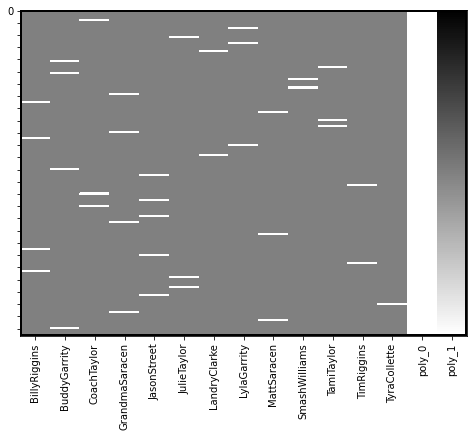

In [3]:
# use `onsets_to_dm()` transfer the onsets file to dm
dm = onsets_to_dm(onsetfile, sampling_freq=sampling_freq, run_length = 160, sort=True, add_poly=1)
dm.heatmap()

Then, we apply the `Design_Matrix` to RepDopa data.

First, load all of the python modules we need to complete this part

In [4]:
%matplotlib inline

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib

from nltools.file_reader import onsets_to_dm
from nltools.stats import regress, zscore
from nltools.data import Brain_Data, Design_Matrix
#from nltools.utils import get_resource_path
from nltools.stats import find_spikes
from nilearn.plotting import view_img, glass_brain, plot_stat_map

from bids import BIDSLayout, BIDSValidator

Second, define the input and output directory

In [5]:
data_dir = '/home/hcp4715/Data/RepDopa/Nipy/BIDS'
layout = BIDSLayout(data_dir, derivatives=True)

#!tree -L 2 {'/home/hcp4715/Data/RepDopa/Nipy/BIDS'} -I '*js|*pklz|_report|*dot|*html|*.m'

/home/hcp4715/miniconda3/envs/py37/lib/python3.7/site-packages/bids/layout/models.py:102: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  FutureWarning)


In [6]:
layout

BIDS Layout: ...hcp4715/Data/RepDopa/Nipy/BIDS | Subjects: 11 | Sessions: 33 | Runs: 44

In [7]:
# check the TRs
nib.load(layout.get(subject='001', session='d1', scope='raw',
                               suffix='bold')[1].path).shape[-1]

496

In [8]:
tr = layout.get_tr()
tr
#tr = layout.get_tr()
n_tr = nib.load(layout.get(subject='001', session='d1', scope='raw',
                               suffix='bold')[1].path).shape[-1]

In [9]:
def recode_trial_type(trial_type):
    """ recode trial type based on needs
    Here, we hope to have a simple contrast for CS+ vs. CS-, therefore we pool all CS- and CS+ (with/without US)
    """
    if trial_type == 'CSplT' or trial_type == 'CSplF':
        return 'CSpl'
    elif trial_type == 'CSminT' or trial_type == 'CSminF':
        return 'CSmin'
    elif trial_type == 'RateCSmin' or trial_type == 'RateCSpl':
        return 'rating'
    elif trial_type == 'ContextOff' or trial_type == 'ContextOn':
        return 'context'

# define a function create design_matrix from BIDS event file

def load_bids_events(layout, subject, session):
    '''
    Create a design_matrix instance from BIDS events file.
    Note: the number of TR is same as the length of preprocessed data by fmriprep
    '''
    
    tr = layout.get_tr()
    n_tr = nib.load(layout.get(subject=subject, 
                               session=session,
                               scope='raw',
                               suffix='bold')[1].path).shape[-1] # Get number of TRs
    onsets = pd.read_csv(layout.get(subject=subject,
                                    session=session,
                                    scope='raw',
                                    suffix='events')[0].path, 
                         sep = '\t')
    onsets.onset = (onsets.onset - onsets.onset[0])/1000
    
    # Get the number of pulses (TRs)
    onsets['cumcount'] = onsets.groupby('trial_type').cumcount()
    # onsets.head()
    pulsenum = onsets[(onsets['trial_type'] == 'Pulse')]
    maxpulse = pulsenum['cumcount'].max()
    pulsenum.head()
    maxpulse

    cutoff_idx = onsets[(onsets['trial_type'] == 'Pulse') & (onsets['cumcount'] == maxpulse)].index.tolist()[0]
    # cutoff_idx


    onsets = onsets.truncate(before=0, after=cutoff_idx)
    
    #onsets = onsets[(onsets['onset']>0)]

    onsets['trial_type'] = onsets['trial_type'].apply(recode_trial_type)
    onsets = onsets[(onsets['trial_type'].notnull())]
    
    onsets = onsets.drop(['ratings', 'cumcount'], axis=1)

    onsets.rename(columns={'onset': 'Onset', 
     #              'duration': 'Duration',
                   'trial_type': 'Stim'}, inplace=True)
    
    return onsets_to_dm(onsets, sampling_freq = 1/tr, run_length=n_tr)

In [10]:
tmpName = layout.get(subject='001', session='d1',  scope='raw',
                                    suffix='events')[0].path
tmpName

'/home/hcp4715/Data/RepDopa/Nipy/BIDS/sub-001/ses-d1/func/sub-001_ses-d1_task-exp_events.tsv'

# of TRs as recorded by presentation:  560


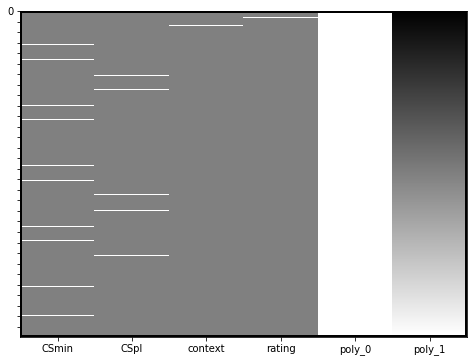

In [11]:
# test the func defined above
tmpName = layout.get(subject='001', session='d1',  scope='raw',
                                    suffix='events')[0].path
onsets = pd.read_csv(tmpName, sep = '\t')
onsets.onset = (onsets.onset - onsets.onset[0])/1000
onsets['cumcount'] = onsets.groupby('trial_type').cumcount()
onsets.head()
pulsenum = onsets[(onsets['trial_type'] == 'Pulse')]
maxpulse = pulsenum['cumcount'].max()
pulsenum.head()
maxpulse

cutoff_idx = onsets[(onsets['trial_type'] == 'Pulse') & (onsets['cumcount'] == maxpulse)].index.tolist()[0]
print('# of TRs as recorded by presentation: ', cutoff_idx)

#onsets_v = onsets.truncate(before=0, after=cutoff_idx)
#print('shape of onsets', onsets.shape)
#print('shape of onsets_v', onsets_v.shape)
#onsets_v.head()

onsets = onsets.truncate(before=0, after=cutoff_idx)

#onsets = onsets[(onsets['onset']>0)]

onsets['trial_type'] = onsets['trial_type'].apply(recode_trial_type)
onsets = onsets[(onsets['trial_type'].notnull())]
onsets

#onsets['duration'] = None

#onsets['duration'].loc[onsets['trial_type'] =='CSmin'] = 5    # CS- last 5 secs
#onsets['duration'].loc[onsets['trial_type'] =='CSpl'] = 5     # CS+ last 5 secs
#onsets['duration'].loc[onsets['trial_type'] =='rating'] = 1   # rating, we assume it is 1 sec
#onsets['duration'].loc[onsets['trial_type'] =='context'] = 1  # onset and offset of context, we assume it is 1 sec

# drop the 'response_time' column, which is not necessary for the current study
onsets = onsets.drop(['ratings', 'cumcount'], axis=1)

onsets.rename(columns={'onset': 'Onset', 
 #              'duration': 'Duration',
               'trial_type': 'Stim'}, inplace=True)
onsets

dm = onsets_to_dm(onsets, sampling_freq = 1/tr, run_length=n_tr, sort=True, add_poly=1)
dm.heatmap()

Third, prepare the onsets file and convert is to desig matrix file

(1), Use pandas to load the text file that contains the onset and duration for each condition of the task. Rows reflect distinct conditions. Conditions are either CS+ or CS-. but also with other condition.

(2), We cast this Pandas DataFrame as a Design_Matrix object. Be sure to specify the sampling frequency, which is $\frac{1}{tr}$.

In [12]:
dm = load_bids_events(layout,'001', 'd1')
dm.head()
print(dm.shape)

(496, 4)


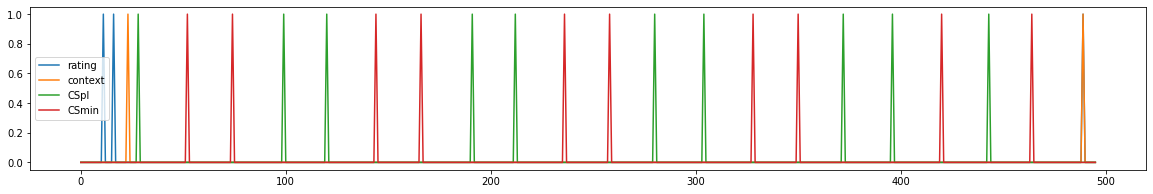

In [13]:
f, a = plt.subplots(figsize=(20,3))
dm.plot(ax=a)

# need to re-check the events files, make sure it is consistent with the TRs

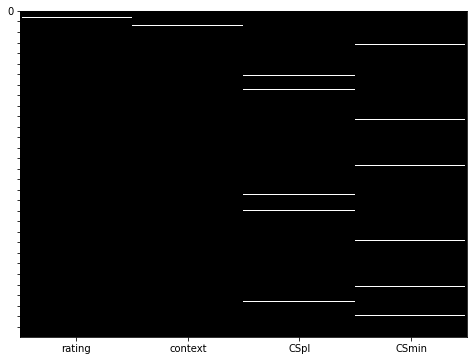

In [14]:
dm.heatmap()

#### HRF Convolution

We've learned about the convoluation in signal processing tutorial. We can now convolve all of the onset regressors with a HRF function using the `.convolve()` method. By default it will convovle all regressors with the standard double gamma HRF function, though you can specify custom onese and also specific regressors to convolve. 

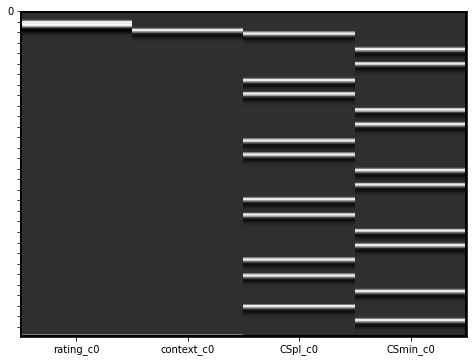

In [15]:
dm_conv = dm.convolve()
dm_conv.heatmap()

Now the regressors is bit blurrier and now has the shape of an HRF function. We can plot a single regressor to see this more clearly using the `.plot` method.

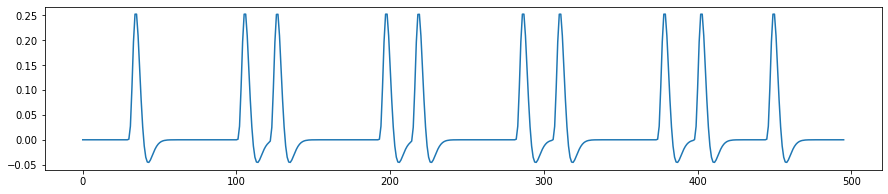

In [16]:
f, a = plt.subplots(figsize=(15,3))
dm_conv['CSpl_c0'].plot(ax=a)

Maybe we want to plot both the CS+ and CS-

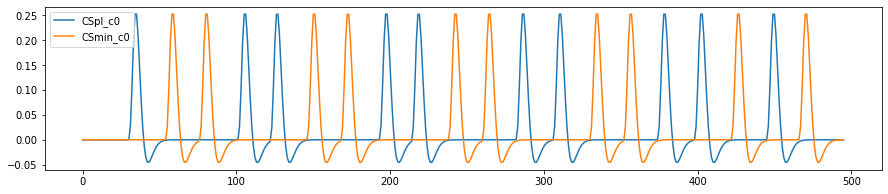

In [17]:
f, a = plt.subplots(figsize=(15,3))
dm_conv[['CSpl_c0', 'CSmin_c0']].plot(ax=a)

### Multicollinearity

$$ Y = b_{0} + b_{1}*X_{1} + b_{2}*X_{2}$$

One way to evalute multicollinearity is to examine the pairwise correlations between each regressors. We plot the correlation matrix as a heatmap.

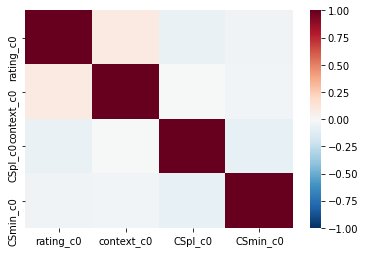

In [18]:
sns.heatmap(dm_conv.corr(), vmin=-1, vmax=1, cmap='RdBu_r')

#### Variance Inflation Factor (VIF)

We are even more concerned about being able to explain any regressor as a linear combination of the other regressos. For example, *Can one regressor be explained by three or more of the remaining regressors?* The variance inflation factor (VIF) is a metric that can help us detect multicollinearity. Specifically, it is simply the ratio of variance in a model with multiple terms, divided by the variance of a model with only a single term.

$$ VIF_{j} = \frac{1}{1 - R_{i}^2} $$

Where $R_{i}^2$ is the $R^2$ value obtained by regressing the $jth$ predictor on the remaining predictors. This means that each regressor $j$ will have it's own variance inflation factor.

How should we interpret the VIF value?

A VIF of 1 indicate that there is no correlation among the $jth$ predictor and the remaining variables. Values greater than 4 should be investigated further, while VIFs exceeding 10 indicate significant multcollinearity and will likely require intervention.

Here we will use the `.vif()` method to calculate the variance inflation factor for our design matrix. 

Text(0, 0.5, 'Variance Inflaction Factor')

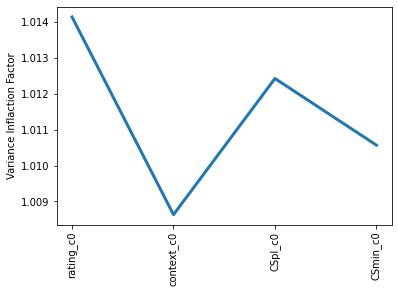

In [19]:
plt.plot(dm_conv.columns, dm_conv.vif(), linewidth=3)
plt.xticks(rotation=90)
plt.ylabel('Variance Inflaction Factor')

#### Orthogonalization

There are many ways to deal with collinearity. In practice, don't worry about collinearity between your covariates. The more pernicious issues are collinearity in your experimental design.

It is commonly thought that using a procedural called orthogonalization should be used to address issues of multicollinearity. In linear algrebra, orthogonalization is the process of prioritizing shared variance between regressors to a single regressor. Recall that the standard GLM already accounts for shared variance by removing it from individual regressors. However, the process of performing this procedure can introduce artifact into the model and often changes the intepretation of the beta weight of the beta weights in unanticipated ways.

In general, we (Luke) do not recommend using orthogonalization in most cases, with the exception of centering regressor variables.

### Nuisance Variables

#### Filtering

It's common to apply a high pass filter to the data to remove low frequency artifact. Often, this can also be addressed by simply using a few polynomials to model these types of trends. If we were to directly filter the brain data using something liek a butterworth filter, we would also need to apply it to our design matrix to make sure that we don't have any low frequency drift in experimental design. One easy way to simultaneously perform both of these procedure is to simply build a filter into the design matrix. 

We will be using a discrete cosine transform (DCT), which is a basis set of cosine regressors of varying frequencies up to a filter cutoff of a specified number of seconds. Many software use 100s or 128s as a default cutoff, but note that the filter cutoff isn't too short for your specific experimental design. Longer trials will require longer filter cutoffs. check relevant papers for details

In [20]:
dm_conv_filt = dm_conv.add_dct_basis(duration=128)

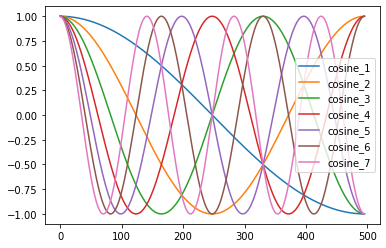

In [21]:
dm_conv_filt.iloc[:,4:].plot()

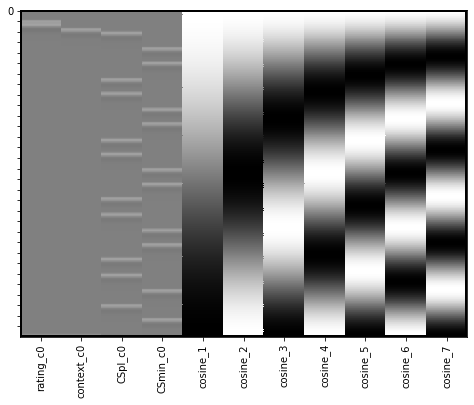

In [22]:
#dm_conv_filt = dm_conv.add_dct_basis(duration=128)
dm_conv_filt.heatmap()

#### Intercepts

We almost always want to include an intercept in our model. This will usually reflect the baseline, or the average voxel response during the times that are note being modeled as a regressors. 

If you are concatenating runs and modeling them all together, it is recommended to include a separate intercept for each run, but not for the entire model. This means that the average response within a voxel might differ across runs. 

You can add an intercept by simply creating a new column of ones (e.g., `dm['Intercept'] = 1`). Here we provide an example using the `.add_poly()` method, which adds an intercept by default

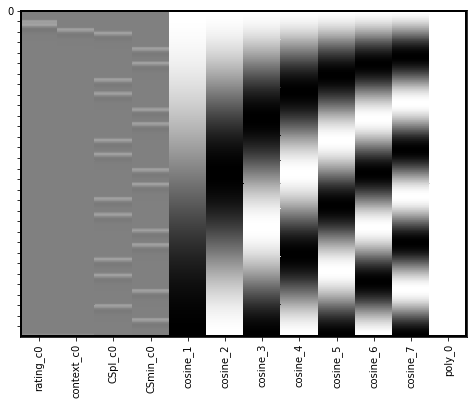

In [23]:
dm_conv_filt_poly = dm_conv_filt.add_poly()
dm_conv_filt_poly.heatmap()

### Linear trends

We also often want to remove any slow drift in our data. This might includ a linear trend and a quadratic trend. We can also do this with `.add_poly()` method and adding all trends up to an order of 2 (e.g., quadratic). We typically use this approach rather than applying a high pass filter when working with naturalistic viewing data.

Notice that these do not appear to be very different from the high pass filter basis set. It's actually okey if there is collinearity in our covariate regressors. Collinearity is only a problem when it correlates with the task regressors as it means that we will not be able to uniquely model the variance. The DCT can occasionally run into edge artifact, which can be addressed by the linear trends.

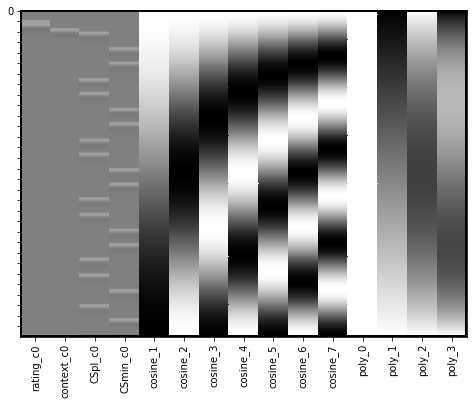

In [24]:
dm_conv_filt_poly = dm_conv_filt.add_poly(order=3, include_lower=True)
dm_conv_filt_poly.heatmap()

### Noise Covariates

Another important thing to consider is removing variance associated with head motion. Remember that the preprocessed data has been already realigned each TR in space, but head motion itself can nonlinearly distort the magnetic field. 

There are several common strategies for trying to remove artifact associated with head motion. 
* One is using a data driven denoising algorithm like ICA and combining it with a classifer such as FSL's `FIX` module. 
* Another approach is to include the amount of correction that needed to be applied to align each TR. 

For example, if someone moved a lot in a single TR, there will be a strong change in their alignment parameters. It's common to include the 6 parameters as covariates in your regression model. However, as we already noted, often motion can have a nonlinear relationship with signal intensity, so it is often good to include other transformation of these signal to capture nonlinear signal changes resulting from head motion. We typeically center the six realignment parameters (or z-score) and then additionally add a quadratic version, a derivative, and the square of the derivatives, which become 24 additional regressors.

In addition, it is common to model out big changes using a regressor with a singl value indicating the timepoint of the movement. this will be zeros along time, with a single value of one at the time point of interest. This effectively removes any varince associated with this single time point. It is import to model each "spike" as separate regressor as there might be distinct spatial partterns associated with different types of head motions. 

**We strongly recommend against using a single continuous frame displacement metric as is often recommended by the fMRIprep team**. This practice assumes (1) that there is a *linear* relationship between displacement and voxel activity, and (2) that there is a single spatial generator or pattern associated with frame displacement. As we saw in the ICA noise lab, there might be many different types of head motion artifacts. This procedure of including spikes as nuisance regressor is mathematically equaivalent to censoring your data and removing the bad TRs. We think it is important to do this in the context of the GLM as it will also reduce the impact if it happens to covary with your task.

First, let's load preprocessed data from one participant.

In [25]:
layout.get(subject='001', session='d1', scope='derivatives',
                             suffix='bold', extension='nii.gz',
                             return_type='file')[0]

'/home/hcp4715/Data/RepDopa/Nipy/BIDS/derivatives/fmriprep/sub-001/ses-d1/func/sub-001_ses-d1_task-exp_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'

In [43]:
sub = '001'
sess = 'd1'
data = Brain_Data(layout.get(subject=sub, session=sess, scope='derivatives',
                             suffix='bold', extension='nii.gz',
                             return_type='file')[0])

In [27]:

#data = data[5:,:] # how to select the volumes from the 5th on
data.shape

<bound method Brain_Data.shape of nltools.data.brain_data.Brain_Data(data=(496, 238955), Y=0, X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz, output_file=[])>

Now, let's insepct the realignment parameters for this participant. These pertain to how much each volume had to be moved in the (X, Y, Z) planes and rotations around each axis. We are standardizing the data so that the rotations and translation are one the same scale.

In [28]:
import time

start = time.time()
layout.get(subject='001', session='d1', scope='derivatives', extension='.tsv')[0].path # need 13.6 GB memory!!!

end = time.time()
print(end - start)

93.76811957359314


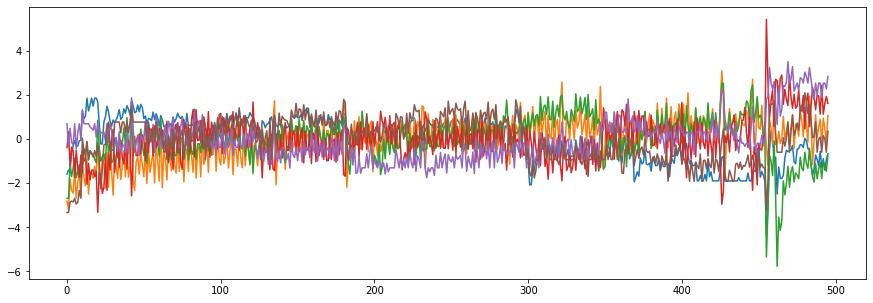

In [29]:
covariates = pd.read_csv(layout.get(subject='001', session='d1', scope='derivatives', extension='.tsv')[0].path, sep='\t')

mc = covariates[['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']]

plt.figure(figsize=(15,5))
plt.plot(zscore(mc))

Now, let's build the 24 covariates related to head motion. We include the 6 realignment parameters that have been standardized. In addition, we add their quadratic, their derivative, and the square of their derivative.


We can create a quick visualization to see what the overall pattern is across the different regressors.

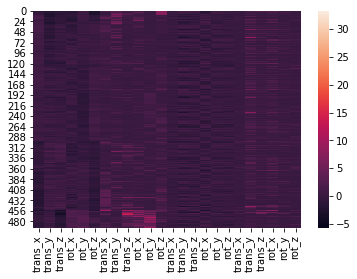

In [30]:
def make_motion_covariates(mc, tr):
    z_mc = zscore(mc)
    all_mc = pd.concat([z_mc, z_mc**2, z_mc.diff(), z_mc.diff()**2], axis=1)
    all_mc.fillna(value=0, inplace=True)
    
    return Design_Matrix(all_mc, sampling_freq=1/tr)

tr = layout.get_tr()
mc_cov = make_motion_covariates(mc, tr)

sns.heatmap(mc_cov)

Now, let's try to find some spikes in the data. This is performed by finding TRs that exceed a global mean threshold and also that exceed an overall average intensity change by a threshold. We are using an arbitrary cutoff of 3 standard devivations as a threshold.

First let's plot the average signal intensity across all voxels over time.

Text(0, 0.5, 'Intensity')

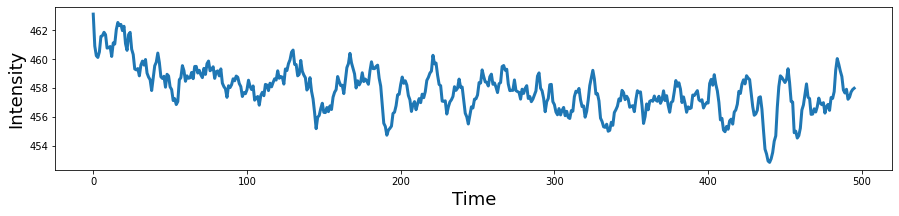

In [31]:
plt.figure(figsize=(15,3))
plt.plot(np.mean(data.data, axis=1), linewidth=3)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Intensity', fontsize=18)

Notice there is a clear slow drift in signal that we will need ot remove with out high pass filter.

Now, let's see if thereare any spikes in the data that exceed our threshold. What happens if we use a different threshold?

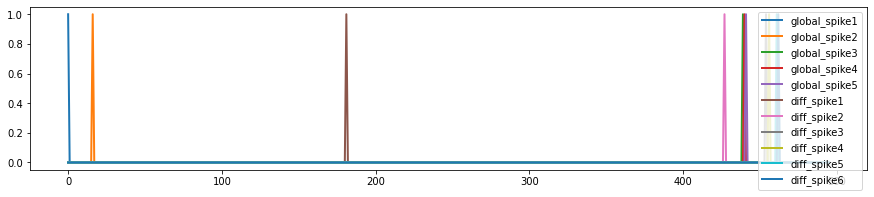

In [32]:
spikes = data.find_spikes(global_spike_cutoff=3, diff_spike_cutoff=3)

f, a = plt.subplots(figsize=(15, 3))
spikes = Design_Matrix(spikes.iloc[:,1:], sampling_freq=1/tr)
spikes.plot(ax=a, linewidth=2)

For this subject, our spike identification procedure found 5 spikes (diff_spike). Let's add all these covariates to our design matrix

In this example, we will append each of these additional matrices to our main design matrix.

Note: `.append()` requires that all matrices are a design_matrix with the same sample frequences.

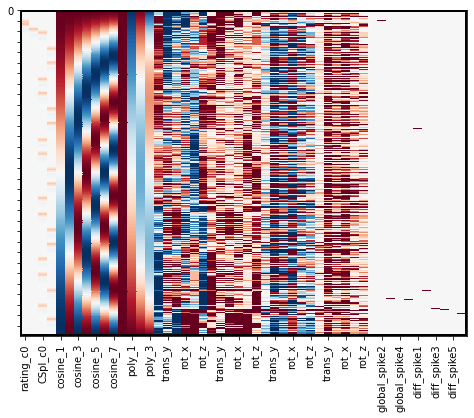

In [33]:
dm_conv_filt_poly_cov = pd.concat([dm_conv_filt_poly, mc_cov, spikes], axis=1)
dm_conv_filt_poly_cov.heatmap(cmap='RdBu_r', vmin=-1, vmax=1)

### Smoothing

To increase the signal-to-noise ratio and clean up the data, it is common to appl spatial smoothing to the image.

Here we will convovle the image with a 3-D gaussian kernel, with a 6 mm full width half maximum (FWHM) using the `.smooth()` method.


In [34]:
fwhm = 6
smoothed = data.smooth(fwhm=fwhm)

Let's take a look and see how this changes the image

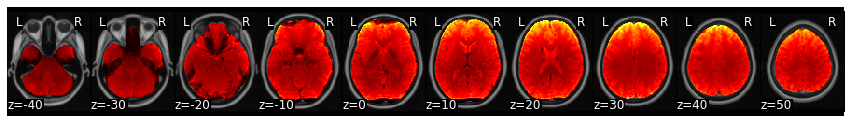

In [35]:
data.mean().plot()

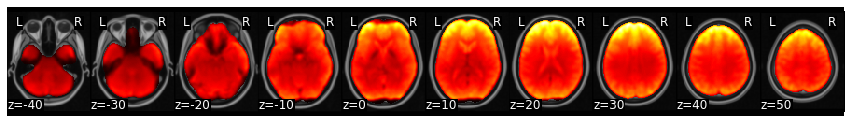

In [36]:
smoothed.mean().plot()

### Esimate GLM for all voxels

Now we are ready to estimate the regression model for all voxels.

We will assign the design_matrix object tothe `.X` attribute of our `Brain_Data` instance.

Then we simply need to run the `regress()` method.

In [37]:
dm_conv_filt_poly_cov.shape

(496, 50)

In [38]:
dm_conv_filt_poly_cov[dm_conv_filt_poly_cov.isin([np.nan, np.inf, -np.inf]).any(1)]

Empty Design_Matrix
Columns: [rating_c0, context_c0, CSpl_c0, CSmin_c0, cosine_1, cosine_2, cosine_3, cosine_4, cosine_5, cosine_6, cosine_7, poly_0, poly_1, poly_2, poly_3, trans_x, trans_y, trans_z, rot_x, rot_y, rot_z, trans_x, trans_y, trans_z, rot_x, rot_y, rot_z, trans_x, trans_y, trans_z, rot_x, rot_y, rot_z, trans_x, trans_y, trans_z, rot_x, rot_y, rot_z, global_spike1, global_spike2, global_spike3, global_spike4, global_spike5, diff_spike1, diff_spike2, diff_spike3, diff_spike4, diff_spike5, diff_spike6]
Index: []

[0 rows x 50 columns]

In [39]:
smoothed.shape

<bound method Brain_Data.shape of nltools.data.brain_data.Brain_Data(data=(496, 238955), Y=0, X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz, output_file=[])>

In [40]:
smoothed.X = dm_conv_filt_poly_cov

stats = smoothed.regress()

print(stats.keys())

dict_keys(['beta', 't', 'p', 'sigma', 'residual'])


OK, it's done!

Let's take a look at the results

Let's first take a look at one of the regressors. The names of each of them are in the column names of the design matrix. which is in the `data.X` field. We can print them to see the names

In [41]:
print(smoothed.X.columns)

Index(['rating_c0', 'context_c0', 'CSpl_c0', 'CSmin_c0', 'cosine_1',
       'cosine_2', 'cosine_3', 'cosine_4', 'cosine_5', 'cosine_6', 'cosine_7',
       'poly_0', 'poly_1', 'poly_2', 'poly_3', 'trans_x', 'trans_y', 'trans_z',
       'rot_x', 'rot_y', 'rot_z', 'trans_x', 'trans_y', 'trans_z', 'rot_x',
       'rot_y', 'rot_z', 'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y',
       'rot_z', 'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z',
       'global_spike1', 'global_spike2', 'global_spike3', 'global_spike4',
       'global_spike5', 'diff_spike1', 'diff_spike2', 'diff_spike3',
       'diff_spike4', 'diff_spike5', 'diff_spike6'],
      dtype='object')


Brain_Data instances ahve their own plotting methods. We will use `.iplot()` here, which allow us to interactively look at all of the values.

If you'd like to see the top values, we can quickly apply a threshold. Trying using `95%` threshold, and be sure to click the `percentile_threshold` option.

In [42]:
#import ipywidgets

stats['beta'][0].iplot()

interactive(children=(FloatText(value=0.0, description='Threshold'), HTML(value='Image is 3D', description='Vo…

### Save Image
We will frequently want to save different brain images we are working with to a nifti file. This is useful for saving intermediate work, or sharing our results with others. This is easy with the `.write()` method. Be sure to specify a path and file name for the file.

**Note**: You can only write to folders where you have permission. 

**Note2**: the directory is super long and will be shorten in the future.

In [45]:
smoothed.write(f'/home/hcp4715/Data/RepDopa/Nipy/BIDS/derivatives/fmriprep/sub-{sub}/ses-{sess}/func/sub-{sub}_ses-{sess}_task-exp_space-MNI152NLin2009cAsym_desc-preproc_beta_denoised_smoothed{fwhm}.nii.gz')

## Contrasts
Now that we have estimated our model, we will likely want to create contrasts to examine brain activation to different conditions.

This procedure is identical to those introduced in the GLM module.

Let's try to make a simple contrast where we average only the regressors pertaining to CS+. This is essentially summing all the CS+ regressors. To take the mean we need to divided the number of regressors.

In [46]:
CSp = np.zeros(len(stats['beta']))
CSp[2] = 1
print(CSp)

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


In [47]:
CSp_beta = stats['beta'] * CSp

CSp_beta.iplot()

interactive(children=(FloatText(value=0.0, description='Threshold'), HTML(value='Image is 3D', description='Vo…

Now, let's see which regions specifically are more active when see CS+ compared to CS-

In [49]:
CS_con = np.zeros(len(stats['beta']))
CS_con[[2, 3]] = [1, -1]

CS_con_beta = stats['beta'] * CS_con

CS_con_beta.iplot()

interactive(children=(FloatText(value=0.0, description='Threshold'), HTML(value='Image is 3D', description='Vo…

## Run 1st level analysis for multiple subjects

In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np

import nibabel as nib
from nilearn.plotting import view_img, glass_brain, plot_stat_map
from bids import BIDSLayout, BIDSValidator

from nltools.stats import zscore, regress, find_spikes
from nltools.data import Brain_Data, Design_Matrix
from nltools.file_reader import onsets_to_dm
from nltools.utils import get_resource_path

data_dir = '/home/hcp4715/Data/RepDopa/Nipy/BIDS'
layout = BIDSLayout(data_dir, derivatives=True)

/home/hcp4715/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/hcp4715/miniconda3/envs/py37/lib/python3.7/site-packages/bids/layout/models.py:102: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  FutureWarning)


In [2]:
tr = layout.get_tr()
fwhm = 6
spike_cutoff = 3

def recode_trial_type(trial_type):
    """ recode trial type based on needs
    Here, we hope to have a simple contrast for CS+ vs. CS-, therefore we pool all CS- and CS+ (with/without US)
    """
    if trial_type == 'CSplT' or trial_type == 'CSplF':
        return 'CSpl'
    elif trial_type == 'CSminT' or trial_type == 'CSminF':
        return 'CSmin'
    elif trial_type == 'RateCSmin' or trial_type == 'RateCSpl':
        return 'rating'
    elif trial_type == 'ContextOff' or trial_type == 'ContextOn':
        return 'context'

# define a function create design_matrix from BIDS event file
def load_bids_events(layout, subject, session):
    '''
    Create a design_matrix instance from BIDS events file.
    Note: the number of TR is same as the length of preprocessed data by fmriprep
    '''
    
    tr = layout.get_tr()
    n_tr = nib.load(layout.get(subject=subject, 
                               session=session,
                               scope='raw',
                               suffix='bold')[1].path).shape[-1] # Get number of TRs
    onsets = pd.read_csv(layout.get(subject=subject,
                                    session=session,
                                    scope='raw',
                                    suffix='events')[0].path, 
                         sep = '\t')
    onsets.onset = (onsets.onset - onsets.onset[0])/1000
    
    # Get the number of pulses (TRs)
    onsets['cumcount'] = onsets.groupby('trial_type').cumcount()
    # onsets.head()
    pulsenum = onsets[(onsets['trial_type'] == 'Pulse')]
    maxpulse = pulsenum['cumcount'].max()
    pulsenum.head()
    maxpulse

    cutoff_idx = onsets[(onsets['trial_type'] == 'Pulse') & (onsets['cumcount'] == maxpulse)].index.tolist()[0]
    # cutoff_idx


    onsets = onsets.truncate(before=0, after=cutoff_idx)
    
    #onsets = onsets[(onsets['onset']>0)]

    onsets['trial_type'] = onsets['trial_type'].apply(recode_trial_type)
    onsets = onsets[(onsets['trial_type'].notnull())]
    
    onsets = onsets.drop(['ratings', 'cumcount'], axis=1)

    onsets.rename(columns={'onset': 'Onset', 
     #              'duration': 'Duration',
                   'trial_type': 'Stim'}, inplace=True)
    
    return onsets_to_dm(onsets, sampling_freq = 1/tr, run_length=n_tr)

In [12]:
def make_motion_covariates(mc):
    z_mc = zscore(mc)
    all_mc = pd.concat([z_mc, z_mc**2, z_mc.diff(), z_mc.diff()**2], axis=1)
    all_mc.fillna(value=0, inplace=True)
    return Design_Matrix(all_mc, sampling_freq=1/tr)

In [4]:
layout.get_subjects(scope='derivatives')

['001', '002', '003', '004', '005']

In [8]:
covariates = pd.read_csv(layout.get(subject='001', session='d1', scope='derivatives', extension='.tsv')[0].path, sep='\t')

In [13]:
mc = covariates[['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']]
spikes = data.find_spikes(global_spike_cutoff=spike_cutoff, diff_spike_cutoff=spike_cutoff)
make_motion_covariates(mc)

trans_x   trans_y   trans_z     rot_x     rot_y     rot_z   trans_x  \
0   -1.583757 -2.804946 -2.685272 -0.390691  0.698933 -3.326238  2.508286   
1   -1.406357 -3.184138 -2.683533  0.333296 -0.315066 -3.326238  1.977841   
2   -1.403812 -1.819462 -1.125849 -1.190257  0.495582 -2.853436  1.970689   
3   -0.631749 -2.334018 -1.690123 -0.361633 -0.156544 -2.807085  0.399106   
4   -0.309531 -2.449952 -1.326280 -0.524207 -0.253934 -2.845376  0.095809   
..        ...       ...       ...       ...       ...       ...       ...   
491 -1.279551 -0.225222 -1.788520  2.441478  1.890756 -0.591196  1.637250   
492 -0.886534  0.949440 -0.997932  1.129830  2.542499  0.154858  0.785943   
493 -1.407302  0.499425 -1.288546  1.622259  2.542499  0.025975  1.980499   
494 -0.927039 -0.148099 -1.452010  1.939444  2.279063 -0.591196  0.859401   
495 -0.660772  1.077047 -0.752209  1.628115  2.850835  0.362910  0.436620   

       trans_y   trans_z     rot_x  ...   trans_z     rot_x     rot_y  \
0     7.867723  7.210686  0.152640  ...  0.000000  0.000000  0.000000   
1    10.138736  7.201348  0.111086  ...  0.001739  0.723987 -1.013999   
2     3.310441  1.267535  1.416712  ...  1.557684 -1.523553  0.810648   
3     5.447638  2.856515  0.130778  ... -0.564274  0.828624 -0.652126   
4     6.002263  1.759020  0.274793  ...  0.363842 -0.162574 -0.097390   
..         ...       ...       ...  ...       ...       ...       ...   
491   0.050725  3.198804  5.960815  ... -0.726344  1.303603 -0.651743   
492   0.901437  0.995869  1.276515  ...  0.790588 -1.311648  0.651743   
493   0.249425  1.660352  2.631724  ... -0.290614  0.492429  0.000000   
494   0.021933  2.108333  3.761443  ... -0.163463  0.317185 -0.263436   
495   1.160030  0.565818  2.650758  ...  0.699801 -0.311329  0.571771   

        rot_z   trans_x   trans_y   trans_z     rot_x     rot_y     rot_z  
0    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
1    0.000000  0.031471  0.143787  0.000003  0.524157  1.028193  0.000000  
2    0.472802  0.000006  1.862341  2.426380  2.321213  0.657150  0.223541  
3    0.046352  0.596082  0.264768  0.318405  0.686619  0.425269  0.002148  
4   -0.038292  0.103824  0.013441  0.132381  0.026430  0.009485  0.001466  
..        ...       ...       ...       ...       ...       ...       ...  
491 -0.690136  0.536380  1.291125  0.527576  1.699381  0.424769  0.476287  
492  0.746054  0.154462  1.379832  0.625029  1.720421  0.424769  0.556596  
493 -0.128883  0.271200  0.202514  0.084457  0.242486  0.000000  0.016611  
494 -0.617171  0.230653  0.419287  0.026720  0.100606  0.069398  0.380900  
495  0.954106  0.070898  1.500983  0.489721  0.096926  0.326922  0.910319  

[496 rows x 24 columns]

In [17]:
file_name = layout.get(subject='001', session='d1', scope='derivatives', suffix='bold', extension='nii.gz', return_type='file')[0]
file_name

'/home/hcp4715/Data/RepDopa/Nipy/BIDS/derivatives/fmriprep/sub-001/ses-d1/func/sub-001_ses-d1_task-exp_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'

In [22]:
os.path.join(os.path.dirname(file_name), f"sub-{sub}_ses-{sess}_betas_denoised_{file_name.split('_')[2]}_{file_name.split('_')[3]}_smoothed{fwhm}_{file_name.split('_')[-1]}")

'/home/hcp4715/Data/RepDopa/Nipy/BIDS/derivatives/fmriprep/sub-001/ses-d1/func/sub-001_ses-d1_betas_denoised_task-exp_space-MNI152NLin2009cAsym_smoothed6_bold.nii.gz'

In [21]:
os.path.dirname(file_name)

'/home/hcp4715/Data/RepDopa/Nipy/BIDS/derivatives/fmriprep/sub-001/ses-d1/func'

In [20]:
os.path.join(os.path.dirname(file_name), f"sub-{sub}_ses-{sess}_betas_denoised_{file_name.split('_')[2]}_smoothed{fwhm}_{file_name.split('_')[-1]}")

'/home/hcp4715/Data/RepDopa/Nipy/BIDS/derivatives/fmriprep/sub-001/ses-d1/func/sub-001_ses-d1_betas_denoised_task-exp_smoothed6_bold.nii.gz'

In [23]:
for sub in layout.get_subjects(scope='derivatives'):
    #tr = layout.get_tr()
    sess = 'd1'
    data = Brain_Data([x for x in layout.get(subject=sub, session=sess, scope='derivatives', suffix='bold', extension='nii.gz', return_type='file') if 'denoised' not in x][0])
    smoothed = data.smooth(fwhm=fwhm)
    
    dm = load_bids_events(layout, subject=sub, session=sess)
    #covariates = pd.read_csv(layout.get(subject='001', session='d1', scope='derivatives', extension='.tsv')[0].path, sep='\t')
    covariates = pd.read_csv(layout.get(subject=sub, session=sess, scope='derivatives', extension='.tsv')[0].path, sep='\t')
    mc = covariates[['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']]
    mc_cov = make_motion_covariates(mc)
    spikes = data.find_spikes(global_spike_cutoff=spike_cutoff, diff_spike_cutoff=spike_cutoff)
    dm_cov = dm.convolve().add_dct_basis(duration=128).add_poly(order=1, include_lower=True)
    dm_cov = dm_cov.append(mc_cov, axis=1).append(Design_Matrix(spikes.iloc[:,1:], sampling_freq=1/tr), axis=1)
    smoothed.X = dm_cov
    
    stats = smoothed.regress()
    file_name = layout.get(subject=sub, session=sess, scope='derivatives', suffix='bold', extension='nii.gz', return_type='file')[0]
    stats['beta'].write(os.path.join(os.path.dirname(file_name), f"sub-{sub}_ses-{sess}_betas_denoised_{file_name.split('_')[2]}_{file_name.split('_')[3]}_smoothed{fwhm}_{file_name.split('_')[-1]}"))
    
    for i, name in enumerate([x[:-3] for x in dm_cov.columns[:10]]):
        stats['beta'][i].write(os.path.join(os.path.dirname(file_name), f"sub-{sub}_ses-{sess}_{name}_betas_denoised_{file_name.split('_')[3]}_smoothed{fwhm}_{file_name.split('_')[-1]}"))


/home/hcp4715/miniconda3/envs/py37/lib/python3.7/site-packages/nltools/file_reader.py:79: UserWarning: Only 2 columns in file, assuming all stimuli are the same duration
  "Only 2 columns in file, assuming all stimuli are the same duration"
/home/hcp4715/miniconda3/envs/py37/lib/python3.7/site-packages/nltools/file_reader.py:79: UserWarning: Only 2 columns in file, assuming all stimuli are the same duration
  "Only 2 columns in file, assuming all stimuli are the same duration"
/home/hcp4715/miniconda3/envs/py37/lib/python3.7/site-packages/nltools/file_reader.py:79: UserWarning: Only 2 columns in file, assuming all stimuli are the same duration
  "Only 2 columns in file, assuming all stimuli are the same duration"
/home/hcp4715/miniconda3/envs/py37/lib/python3.7/site-packages/nltools/file_reader.py:79: UserWarning: Only 2 columns in file, assuming all stimuli are the same duration
  "Only 2 columns in file, assuming all stimuli are the same duration"
/home/hcp4715/miniconda3/envs/py37/l